In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:

%pip install torch tensorboard
%pip install transformers datasets accelerate evaluate trl protobuf sentencepiece
%pip install flash-attn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 98.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.8.3-cp312-cp312-linux_x86_64.whl size=253780426 sha256=4e2f9e39313266b1544b68138b15b91ee6221eccf14f7902b7c6620351340810
  Stored in directory: /root/.cache/pip/wheels/3d/59/46/f282c12c73dd4bb3c2e3fe199f1a0d0f8cec06df0cccfeee27
Successfully built flash-attn


# Hugging Face configuration for pushing final model

In [ ]:
import os


hf_token = "xxxx"
hf_repo_name = "bhaiya45/functiongemma-multiagent-router"



In [5]:
# Login into Hugging Face Hub
from huggingface_hub import login
login()


# **Multi-Agent System: Customer Support Platform**
#
# We'll create a routing system for a customer support platform with 3 specialized agents:
#
# 1. **Technical Support Agent**: Handles technical issues, bugs, and troubleshooting
# 2. **Billing Agent**: Manages invoices, payments, subscriptions, and refunds
# 3. **Product Information Agent**: Provides product details, features, and recommendations

In [6]:
# -*- coding: utf-8 -*-
"""Fine-tuning with FunctionGemma for OEE Tool

Automatically generated based on user request.
"""

import re
import json
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import SFTConfig, SFTTrainer
import matplotlib.pyplot as plt

# --- Configuration ---
base_model = "google/functiongemma-270m-it"
checkpoint_dir = "functiongemma-270m-it-multiagent-router"
learning_rate = 5e-5


Multi-Agent Routing Dataset

In [7]:
multi_agent_dataset = [
    # Technical Support Agent queries - MORE VARIED AND REALISTIC
    {"user_content": "My app keeps crashing when I try to upload photos larger than 5MB", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "crash", "priority": "high"}'},
    {"user_content": "I can't log in, it says my password is incorrect but I'm sure it's right", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "authentication", "priority": "high"}'},
    {"user_content": "The dashboard takes forever to load, sometimes over 30 seconds", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "performance", "priority": "medium"}'},
    {"user_content": "How do I connect your REST API to my Node.js backend?", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "integration", "priority": "medium"}'},
    {"user_content": "Getting error 500 when calling the /api/users endpoint", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "api_error", "priority": "high"}'},
    {"user_content": "My mobile app data isn't syncing with the cloud storage", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "sync", "priority": "medium"}'},
    {"user_content": "Need help configuring 2FA with Google Authenticator", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "security_setup", "priority": "low"}'},
    {"user_content": "My CSV export keeps failing after processing 50% of the data", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "export", "priority": "medium"}'},
    {"user_content": "Search results are showing outdated information from last month", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "functionality", "priority": "medium"}'},
    {"user_content": "Can't connect to VPN from my home WiFi network", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "connectivity", "priority": "high"}'},
    {"user_content": "Getting 403 forbidden when trying to access the admin dashboard", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "permissions", "priority": "high"}'},
    {"user_content": "Desktop app installation fails on Windows 11 with error code 0x80070057", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "installation", "priority": "medium"}'},
    {"user_content": "My webhook isn't receiving POST requests from your system", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "webhook", "priority": "medium"}'},
    {"user_content": "Database queries are timing out after 30 seconds", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "database", "priority": "high"}'},
    {"user_content": "SSL certificate error when accessing the API over HTTPS", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "ssl", "priority": "medium"}'},
    {"user_content": "The app freezes when I try to edit large documents", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "performance", "priority": "high"}'},
    {"user_content": "Getting 'session expired' error every 5 minutes", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "authentication", "priority": "medium"}'},
    {"user_content": "How do I set up OAuth2 authentication for my integration?", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "integration", "priority": "low"}'},
    {"user_content": "Push notifications aren't working on my Android device", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "functionality", "priority": "medium"}'},
    {"user_content": "Unable to restore backup from last week", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "database", "priority": "high"}'},

    # Billing Agent queries - MORE VARIED AND REALISTIC
    {"user_content": "I see two charges of $99 on my credit card for this month", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "dispute", "urgency": "high"}'},
    {"user_content": "I'd like a refund for the annual plan I purchased yesterday", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "refund", "urgency": "medium"}'},
    {"user_content": "My credit card expires next month, how do I update it?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "payment_method", "urgency": "low"}'},
    {"user_content": "Where can I find my September invoice for accounting purposes?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "invoice", "urgency": "low"}'},
    {"user_content": "I want to upgrade from Basic to Premium, what's the price difference?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "upgrade", "urgency": "medium"}'},
    {"user_content": "How do I cancel my subscription before the renewal on March 15th?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "cancellation", "urgency": "medium"}'},
    {"user_content": "My payment was declined but I have sufficient funds in my account", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "payment_failure", "urgency": "high"}'},
    {"user_content": "Can I switch from monthly billing to annual to save money?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "billing_cycle", "urgency": "low"}'},
    {"user_content": "I need to change the billing email from old@company.com to new@company.com", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "account_update", "urgency": "low"}'},
    {"user_content": "What features are included in the Enterprise plan pricing?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "pricing_inquiry", "urgency": "low"}'},
    {"user_content": "I was charged $149 but my account still shows as unpaid", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "payment_discrepancy", "urgency": "high"}'},
    {"user_content": "Does your company offer educational discounts for universities?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "discount", "urgency": "low"}'},
    {"user_content": "I need to add 5 more user licenses to my current team plan", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "add_seats", "urgency": "medium"}'},
    {"user_content": "Can you provide a tax exemption form for our non-profit organization?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "tax", "urgency": "low"}'},
    {"user_content": "Is it possible to pause my subscription for 3 months while I'm on sabbatical?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "pause_subscription", "urgency": "medium"}'},
    {"user_content": "I was charged after canceling, can I get that refunded?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "refund", "urgency": "high"}'},
    {"user_content": "How do I apply the promotional code SAVE20 to my account?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "discount", "urgency": "medium"}'},
    {"user_content": "My company needs a quote for 50 enterprise licenses", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "pricing_inquiry", "urgency": "medium"}'},
    {"user_content": "Can I downgrade from Premium to Basic and get a prorated refund?", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "upgrade", "urgency": "low"}'},
    {"user_content": "Need to update our billing address for tax purposes", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "account_update", "urgency": "low"}'},

    # Product Information Agent queries - MORE VARIED AND REALISTIC
    {"user_content": "What's the difference between Pro and Enterprise in terms of storage limits?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "comparison", "category": "plans"}'},
    {"user_content": "Does your platform support real-time collaborative editing like Google Docs?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "features", "category": "capabilities"}'},
    {"user_content": "Which project management tools can I integrate with your platform?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "integrations", "category": "project_management"}'},
    {"user_content": "What's the maximum file size I can upload on the Basic plan?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "limits", "category": "storage"}'},
    {"user_content": "Is there a native mobile app for iOS and Android?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "platform", "category": "mobile"}'},
    {"user_content": "Are you HIPAA compliant for healthcare data?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "compliance", "category": "healthcare"}'},
    {"user_content": "What kind of analytics and reporting dashboards do you provide?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "features", "category": "analytics"}'},
    {"user_content": "Is there an API rate limit on the Standard plan?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "limits", "category": "api"}'},
    {"user_content": "Do you have SOC 2 Type II certification?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "compliance", "category": "security"}'},
    {"user_content": "Can I customize the interface with my company's branding and colors?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "customization", "category": "branding"}'},
    {"user_content": "What features were added in the latest version 3.5 release?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "updates", "category": "releases"}'},
    {"user_content": "Does your product support SSO with Microsoft Azure AD?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "integrations", "category": "authentication"}'},
    {"user_content": "How many team members can I have on the Standard plan?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "limits", "category": "users"}'},
    {"user_content": "What languages is your user interface available in?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "localization", "category": "languages"}'},
    {"user_content": "Can I export reports to PDF and Excel formats?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "features", "category": "export"}'},
    {"user_content": "Does the Enterprise plan include dedicated customer support?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "comparison", "category": "plans"}'},
    {"user_content": "What's your uptime SLA for production environments?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "compliance", "category": "security"}'},
    {"user_content": "Can I integrate with Salesforce CRM?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "integrations", "category": "project_management"}'},
    {"user_content": "Is there a limit on how many API calls I can make per day?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "limits", "category": "api"}'},
    {"user_content": "Do you support custom workflow automation?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "features", "category": "capabilities"}'},

    # EDGE CASES - Ambiguous queries that could confuse the model
    {"user_content": "I need help with my account", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "account_update", "urgency": "medium"}'},
    {"user_content": "Something is broken", "agent_name": "technical_support_agent", "agent_arguments": '{"issue_type": "functionality", "priority": "medium"}'},
    {"user_content": "Tell me about your pricing", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "pricing_inquiry", "urgency": "low"}'},
    {"user_content": "What can your product do?", "agent_name": "product_info_agent", "agent_arguments": '{"query_type": "features", "category": "capabilities"}'},
    {"user_content": "I have a problem with my subscription", "agent_name": "billing_agent", "agent_arguments": '{"request_type": "account_update", "urgency": "medium"}'},
]

print(f"✅ Created {len(multi_agent_dataset)} training samples with improved variety and realism")


✅ Created 65 training samples with improved variety and realism


Agent Tool Definitions

In [8]:
import json
from datasets import Dataset
from transformers.utils import get_json_schema

# --- Agent Tool Definitions ---
def technical_support_agent(issue_type: str, priority: str) -> str:
    """
    Routes technical issues to the specialized technical support team.

    Args:
        issue_type: Type of technical issue (e.g., 'crash', 'authentication', 'performance', 'api_error', 'integration')
        priority: Priority level of the issue ('low', 'medium', 'high')
    """
    return f"Routing to Technical Support: {issue_type} with {priority} priority"

def billing_agent(request_type: str, urgency: str) -> str:
    """
    Routes billing, payment, subscription, and invoicing queries to the billing department.

    Args:
        request_type: Type of billing request (e.g., 'refund', 'invoice', 'upgrade', 'cancellation', 'dispute')
        urgency: How urgent the request is ('low', 'medium', 'high')
    """
    return f"Routing to Billing: {request_type} with {urgency} urgency"

def product_info_agent(query_type: str, category: str) -> str:
    """
    Routes product information queries including features, plans, integrations, and capabilities.

    Args:
        query_type: Type of product query (e.g., 'features', 'comparison', 'integrations', 'limits', 'compliance')
        category: Specific category of the query (e.g., 'plans', 'storage', 'mobile', 'security')
    """
    return f"Routing to Product Info: {query_type} about {category}"

In [9]:
# Create tools list
AGENT_TOOLS = [
    get_json_schema(technical_support_agent),
    get_json_schema(billing_agent),
    get_json_schema(product_info_agent)
]

In [10]:
DEFAULT_SYSTEM_MSG = "You are an intelligent routing agent that directs customer queries to the appropriate specialized agent based on the nature of their request."

def create_conversation(sample):
    # Parse the arguments to ensure we only keep the actual parameters
    arguments = json.loads(sample["agent_arguments"])

    return {
        "messages": [
            {"role": "developer", "content": DEFAULT_SYSTEM_MSG},
            {"role": "user", "content": sample["user_content"]},
            {"role": "assistant", "tool_calls": [{"type": "function", "function": {"name": sample["agent_name"], "arguments": arguments}}]},
        ],
        "tools": AGENT_TOOLS
    }

In [11]:
# Create dataset
dataset = Dataset.from_list(multi_agent_dataset)

# Convert dataset to conversational format
dataset = dataset.map(create_conversation, remove_columns=dataset.features, batched=False)

# Split dataset into 50% training samples and 50% test samples
dataset = dataset.train_test_split(test_size=0.3, shuffle=True, seed=42)

print(f"Training samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

Map:   0%|          | 0/65 [00:00<?, ? examples/s]

Training samples: 45
Test samples: 20


Load Model and Tokenizer

In [12]:
# %%
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    dtype="auto",
    device_map="auto",
    attn_implementation="eager"
)
tokenizer = AutoTokenizer.from_pretrained(base_model)

print(f"Device: {model.device}")
print(f"DType: {model.dtype}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/176 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/63.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/13.8k [00:00<?, ?B/s]

Device: cuda:0
DType: torch.bfloat16


In [13]:
# Print formatted user prompt
print("\n--- Sample Dataset Input ---")
sample_data = dataset["train"][0]
print(f"User Query: {sample_data['messages'][1]['content']}")
print(f"Expected Agent: {sample_data['messages'][2]['tool_calls'][0]['function']['name']}")
print(f"Expected Arguments: {sample_data['messages'][2]['tool_calls'][0]['function']['arguments']}")

debug_msg = tokenizer.apply_chat_template(sample_data["messages"], tools=sample_data["tools"], add_generation_prompt=False, tokenize=False)
print("\n--- Formatted Prompt (first 500 chars) ---")
print(debug_msg[:500] + "...")


--- Sample Dataset Input ---
User Query: What's your uptime SLA for production environments?
Expected Agent: product_info_agent
Expected Arguments: {'category': 'security', 'issue_type': None, 'priority': None, 'query_type': 'compliance', 'request_type': None, 'urgency': None}

--- Formatted Prompt (first 500 chars) ---
<bos><start_of_turn>developer
You are an intelligent routing agent that directs customer queries to the appropriate specialized agent based on the nature of their request.<start_function_declaration>declaration:technical_support_agent{description:<escape>Routes technical issues to the specialized technical support team.<escape>,parameters:{properties:{category:{description:<escape><escape>,type:<escape><escape>},issue_type:{description:<escape>Type of technical issue (e.g., 'crash', 'authenticat...


Before Fine-tuning Evaluation

In [14]:
# Inspect dataset structure to debug None values
print("🔍 Inspecting dataset structure...")
print("\n--- First Training Sample ---")
first_sample = dataset['train'][0]
print(f"Messages: {first_sample['messages']}")
print(f"\nExpected tool call:")
print(f"  Name: {first_sample['messages'][2]['tool_calls'][0]['function']['name']}")
print(f"  Arguments: {first_sample['messages'][2]['tool_calls'][0]['function']['arguments']}")
print(f"  Argument type: {type(first_sample['messages'][2]['tool_calls'][0]['function']['arguments'])}")

# %%
# Debug cell - Check a single sample to see raw output
print("\n🔍 DEBUG: Testing single sample to see model output format\n")
test_sample = dataset['test'][0]
messages = [test_sample["messages"][0], test_sample["messages"][1]]

inputs = tokenizer.apply_chat_template(messages, tools=AGENT_TOOLS, add_generation_prompt=True, return_dict=True, return_tensors="pt")
out = model.generate(**inputs.to(model.device), pad_token_id=tokenizer.eos_token_id, max_new_tokens=128)
output = tokenizer.decode(out[0][len(inputs["input_ids"][0]):], skip_special_tokens=False)

print(f"Query: {test_sample['messages'][1]['content']}")
print(f"\nExpected Agent: {test_sample['messages'][2]['tool_calls'][0]['function']['name']}")
print(f"Expected Args: {test_sample['messages'][2]['tool_calls'][0]['function']['arguments']}")
print(f"\n{'='*80}")
print("Raw Model Output:")
print(output)
print('='*80)

🔍 Inspecting dataset structure...

--- First Training Sample ---
Messages: [{'content': 'You are an intelligent routing agent that directs customer queries to the appropriate specialized agent based on the nature of their request.', 'role': 'developer', 'tool_calls': None}, {'content': "What's your uptime SLA for production environments?", 'role': 'user', 'tool_calls': None}, {'content': None, 'role': 'assistant', 'tool_calls': [{'function': {'arguments': {'category': 'security', 'issue_type': None, 'priority': None, 'query_type': 'compliance', 'request_type': None, 'urgency': None}, 'name': 'product_info_agent'}, 'type': 'function'}]}]

Expected tool call:
  Name: product_info_agent
  Arguments: {'category': 'security', 'issue_type': None, 'priority': None, 'query_type': 'compliance', 'request_type': None, 'urgency': None}
  Argument type: <class 'dict'>

🔍 DEBUG: Testing single sample to see model output format

Query: What features are included in the Enterprise plan pricing?

Expec

In [15]:
import re

def extract_function_call(output):
    """
    Extract function name and arguments from model output.
    Based on working pattern: <start_function_call>call:func_name{param1:value1,param2:value2}<end_function_call>
    Handles both escaped strings and unescaped literals (true, false, numbers).
    """
    try:
        # Pattern to match function calls: call:func_name{params}
        function_call_pattern = r'<start_function_call>call:(\w+)\{([^}]+)\}<end_function_call>'
        match = re.search(function_call_pattern, output)

        if match:
            func_name = match.group(1)
            params_str = match.group(2)
            params = {}

            # Regex to extract parameters
            # Handles: param:<escape>value<escape> OR param:value
            param_pattern = r'(\w+):(?:<escape>(.*?)<escape>|([^,{}]+))'
            param_matches = re.finditer(param_pattern, params_str)

            for p_match in param_matches:
                key = p_match.group(1)
                val_escaped = p_match.group(2)
                val_simple = p_match.group(3)

                if val_escaped is not None:
                    final_val = val_escaped
                else:
                    final_val = val_simple.strip()
                    # Cast booleans and numbers
                    if final_val.lower() == 'true':
                        final_val = True
                    elif final_val.lower() == 'false':
                        final_val = False
                    elif final_val.isdigit():
                        final_val = int(final_val)

                params[key] = final_val

            return {"function_name": func_name, "arguments": params}

        # Fallback: check if function name appears anywhere
        for agent in ["technical_support_agent", "billing_agent", "product_info_agent"]:
            if agent in output:
                return {"function_name": agent, "arguments": {}}

    except Exception as e:
        print(f"   [Debug] Extract error: {e}")

    # Always return a valid dict, never None
    return {"function_name": "NONE", "arguments": {}}

In [21]:
def evaluate_routing(dataset_split, model, tokenizer, phase="BEFORE"):
    """Evaluate routing accuracy and collect results"""
    success_count = 0
    total_tests = len(dataset_split)
    results = []

    print(f"\n{'='*100}")
    print(f"📊 {phase} FINE-TUNING EVALUATION - Testing {total_tests} samples")
    print(f"{'='*100}\n")

    for idx, item in enumerate(dataset_split):
        messages = [
            item["messages"][0],
            item["messages"][1],
        ]

        inputs = tokenizer.apply_chat_template(messages, tools=AGENT_TOOLS, add_generation_prompt=True, return_dict=True, return_tensors="pt")

        out = model.generate(**inputs.to(model.device), pad_token_id=tokenizer.eos_token_id, max_new_tokens=128)
        output = tokenizer.decode(out[0][len(inputs["input_ids"][0]):], skip_special_tokens=False)

        # Extract expected values (only the actual parameters, not all possible ones)
        expected_agent = item['messages'][2]['tool_calls'][0]['function']['name']
        expected_args = item['messages'][2]['tool_calls'][0]['function']['arguments']

        # Extract predicted values
        predicted = extract_function_call(output)
        predicted_agent = predicted['function_name']
        predicted_args = predicted['arguments']

        # Debug: Print raw output for first few samples
        if idx < 3 and phase == "BEFORE":
            print(f"\n[DEBUG] Raw model output for sample {idx+1}:")
            print(output[:300])
            print(f"[DEBUG] Extracted: {predicted_agent}({predicted_args})\n")

        # Check if correct
        other_agents = [agent for agent in ["technical_support_agent", "billing_agent", "product_info_agent"] if agent != expected_agent]
        is_correct = expected_agent == predicted_agent and not any(agent in output for agent in other_agents)

        # Store result
        result = {
            "query": item['messages'][1]['content'],
            "expected_agent": expected_agent,
            "expected_arguments": expected_args,
            "predicted_agent": predicted_agent,
            "predicted_arguments": predicted_args,
            "raw_output": output[:200],
            "correct": is_correct
        }
        results.append(result)

        # Print result
        status = "✅ CORRECT" if is_correct else "❌ WRONG"
        print(f"{idx+1}. Query: {result['query'][:80]}...")
        print(f"   Expected:  {expected_agent}{json.dumps(expected_args, ensure_ascii=False)}")
        print(f"   Predicted: {predicted_agent}{json.dumps(predicted_args, ensure_ascii=False)}")
        print(f"   {status}\n")

        if is_correct:
            success_count += 1

    accuracy = (success_count / total_tests) * 100
    print(f"\n{'='*100}")
    print(f"🎯 Routing Accuracy: {success_count}/{total_tests} ({accuracy:.1f}%)")
    print(f"{'='*100}\n")

    return results, success_count, total_tests, accuracy

In [20]:
print("🔍 Evaluating model BEFORE fine-tuning...")
results_before, success_before, total_before, accuracy_before = evaluate_routing(
    dataset['test'], model, tokenizer, phase="BEFORE"
)

🔍 Evaluating model BEFORE fine-tuning...

📊 BEFORE FINE-TUNING EVALUATION - Testing 20 samples


[DEBUG] Raw model output for sample 1:
<start_function_call>call:product_info_agent{category:<escape>plans<escape>,query_type:<escape>features<escape>}<end_function_call><start_function_response>
[DEBUG] Extracted: product_info_agent({'category': 'plans', 'query_type': 'features'})

1. Query: What features are included in the Enterprise plan pricing?...
   Expected:  billing_agent{"category": null, "issue_type": null, "priority": null, "query_type": null, "request_type": "pricing_inquiry", "urgency": "low"}
   Predicted: product_info_agent{"category": "plans", "query_type": "features"}
   ❌ WRONG


[DEBUG] Raw model output for sample 2:
I can assist with managing various project management tools. To recommend the best integration for you, could you please specify the type of project management tools you need assistance with?<end_of_turn>
[DEBUG] Extracted: NONE({})

2. Query: Which project 

**Training Configuration**

#
# **⚙️ Configuration Notes:**
# - This configuration is optimized for **FREE T4 GPU on Google Colab**
# - Batch size: 4 (to fit in 16GB VRAM)
# - Epochs: 10 (good balance for 45 training samples)
# - No gradient checkpointing (faster training on T4)
#
# **📈 For Larger Datasets or More Epochs:**
# - You'll need **Colab Pro/Pro+** with A100 or V100 GPUs
# - Can increase batch size to 8-16
# - Can train for 15-20 epochs
# - Can add gradient checkpointing for larger models

In [22]:
from trl import SFTConfig

torch_dtype = model.dtype

args = SFTConfig(
    output_dir=checkpoint_dir,              # directory to save and repository id
    max_length=512,                         # max sequence length for model and packing of the dataset
    packing=False,                          # Groups multiple samples in the dataset into a single sequence
    num_train_epochs=8,                     # number of training epochs
    per_device_train_batch_size=4,          # batch size per device during training
    gradient_checkpointing=False,           # Caching is incompatible with gradient checkpointing
    optim="adamw_torch_fused",              # use fused adamw optimizer
    logging_steps=1,                        # log every step
    #save_strategy="epoch",                  # save checkpoint every epoch
    eval_strategy="epoch",                  # evaluate checkpoint every epoch
    learning_rate=learning_rate,            # learning rate
    fp16=True if torch_dtype == torch.float16 else False,   # use float16 precision
    bf16=True if torch_dtype == torch.bfloat16 else False,  # use bfloat16 precision
    lr_scheduler_type="constant",            # use constant learning rate scheduler
    push_to_hub=True,                        # push model to hub
    report_to="tensorboard",                 # report metrics to tensorboard
)

Start Training

In [23]:
from trl import SFTTrainer

# Create Trainer object
trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    processing_class=tokenizer,
)

Tokenizing train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/45 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/20 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [24]:
# Start training
trainer.train()

# Save the final model
trainer.save_model()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 1, 'bos_token_id': 2, 'pad_token_id': 0}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.196200,0.157005,0.133851,19593.000000,0.974328
2,0.078300,0.113901,0.099194,39186.000000,0.977402
3,0.055200,0.132625,0.046795,58779.000000,0.978459
4,0.053100,0.117773,0.050600,78372.000000,0.979423
5,0.027100,0.128225,0.040478,97965.000000,0.979231
6,0.012000,0.121445,0.046140,117558.000000,0.979135
7,0.026300,0.119016,0.044740,137151.000000,0.979616
8,0.019400,0.122021,0.042498,156744.000000,0.980191


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...-router/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...171791.1bbe48e42d74.184.0: 100%|##########| 46.1kB / 46.1kB            

  ...nt-router/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...ent-router/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...-router/model.safetensors:   3%|3         | 16.8MB /  536MB            

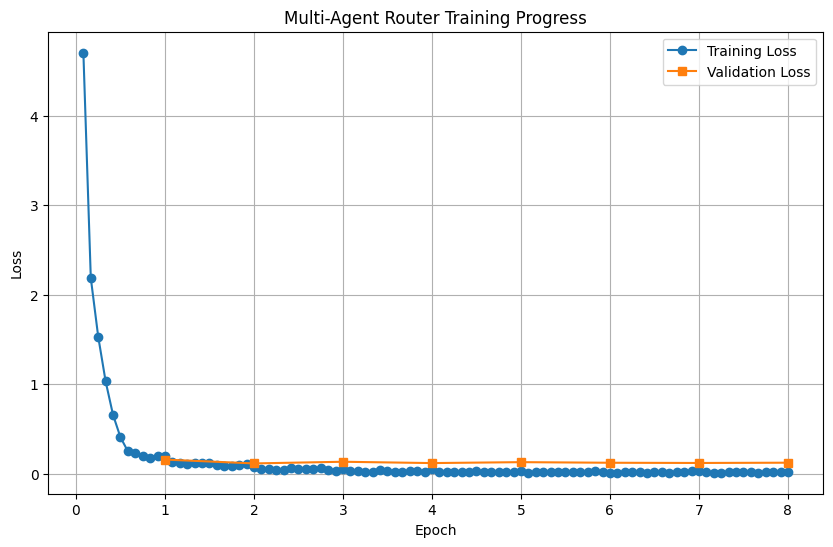

In [25]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(epoch_train, train_losses, label="Training Loss", marker='o')
plt.plot(epoch_eval, eval_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Multi-Agent Router Training Progress")
plt.legend()
plt.grid(True)
plt.show()

## After Fine-tuning Evaluation

In [26]:
print("🔍 Evaluating model AFTER fine-tuning...")
results_after, success_after, total_after, accuracy_after = evaluate_routing(
    dataset['test'], model, tokenizer, phase="AFTER"
)


🔍 Evaluating model AFTER fine-tuning...

📊 AFTER FINE-TUNING EVALUATION - Testing 20 samples

1. Query: What features are included in the Enterprise plan pricing?...
   Expected:  billing_agent{"category": null, "issue_type": null, "priority": null, "query_type": null, "request_type": "pricing_inquiry", "urgency": "low"}
   Predicted: product_info_agent{"category": "plans", "query_type": "features"}
   ❌ WRONG

2. Query: Which project management tools can I integrate with your platform?...
   Expected:  product_info_agent{"category": "project_management", "issue_type": null, "priority": null, "query_type": "integrations", "request_type": null, "urgency": null}
   Predicted: product_info_agent{"category": "capabilities", "query_type": "features"}
   ✅ CORRECT

3. Query: Push notifications aren't working on my Android device...
   Expected:  technical_support_agent{"category": null, "issue_type": "functionality", "priority": "medium", "query_type": null, "request_type": null, "urgency": 

In [27]:
import json
from datetime import datetime

# Prepare comparison data
comparison_data = {
    "metadata": {
        "base_model": base_model,
        "training_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "num_train_samples": len(dataset['train']),
        "num_test_samples": len(dataset['test']),
        "num_epochs": args.num_train_epochs,
        "learning_rate": learning_rate,
        "batch_size": args.per_device_train_batch_size,
    },
    "performance": {
        "before_training": {
            "accuracy": accuracy_before,
            "correct": success_before,
            "total": total_before
        },
        "after_training": {
            "accuracy": accuracy_after,
            "correct": success_after,
            "total": total_after
        },
        "improvement": {
            "accuracy_gain": accuracy_after - accuracy_before,
            "additional_correct": success_after - success_before
        }
    },
    "detailed_results": {
        "before_training": results_before,
        "after_training": results_after
    }
}


In [28]:
# Save to JSON file
output_json_path = f"{checkpoint_dir}/evaluation_results.json"
os.makedirs(checkpoint_dir, exist_ok=True)

with open(output_json_path, 'w') as f:
    json.dump(comparison_data, f, indent=2)

print(f"✅ Results saved to: {output_json_path}")

# Display summary
print("\n" + "="*100)
print("📊 TRAINING RESULTS SUMMARY")
print("="*100)
print(f"Before Training: {success_before}/{total_before} ({accuracy_before:.1f}%)")
print(f"After Training:  {success_after}/{total_after} ({accuracy_after:.1f}%)")
print(f"Improvement:     +{success_after - success_before} correct (+{accuracy_after - accuracy_before:.1f}%)")
print("="*100 + "\n")

✅ Results saved to: functiongemma-270m-it-multiagent-router/evaluation_results.json

📊 TRAINING RESULTS SUMMARY
Before Training: 0/20 (0.0%)
After Training:  18/20 (90.0%)
Improvement:     +18 correct (+90.0%)



# Final Visualization & Analysis

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from IPython.display import display, HTML

# Create comprehensive visualization with 6 subplots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        '🎯 Routing Accuracy Comparison',
        '📈 Prediction Distribution',
        '📉 Training Progress',
        '🤖 Before Training: Per-Agent Accuracy',
        '🤖 After Training: Per-Agent Accuracy',
        '📊 Per-Agent Improvement'
    ),
    specs=[
        [{"type": "bar"}, {"type": "bar"}],
        [{"type": "scatter"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "bar"}]
    ],
    vertical_spacing=0.12,
    horizontal_spacing=0.15
)

# 1. Accuracy Comparison
phases = ['Before<br>Training', 'After<br>Training']
accuracies = [accuracy_before, accuracy_after]
colors_acc = ['#ff6b6b', '#51cf66']

fig.add_trace(go.Bar(
    x=phases,
    y=accuracies,
    text=[f'{acc:.1f}%' for acc in accuracies],
    textposition='outside',
    marker=dict(color=colors_acc, line=dict(color='black', width=2)),
    showlegend=False
), row=1, col=1)

fig.update_yaxes(range=[0, 100], title_text='Accuracy (%)', row=1, col=1)

In [30]:
# 2. Correct vs Incorrect Predictions
categories = ['Before Training', 'After Training']
correct_counts = [success_before, success_after]
incorrect_counts = [total_before - success_before, total_after - success_after]

fig.add_trace(go.Bar(
    x=categories,
    y=correct_counts,
    name='✅ Correct',
    marker_color='#51cf66',
    text=correct_counts,
    textposition='inside'
), row=1, col=2)

fig.add_trace(go.Bar(
    x=categories,
    y=incorrect_counts,
    name='❌ Incorrect',
    marker_color='#ff6b6b',
    text=incorrect_counts,
    textposition='inside'
), row=1, col=2)

fig.update_yaxes(title_text='Number of Predictions', row=1, col=2)
fig.update_layout(barmode='stack')

In [31]:
# 3. Training & Validation Loss
fig.add_trace(go.Scatter(
    x=epoch_train,
    y=train_losses,
    mode='lines+markers',
    name='Training Loss',
    line=dict(color='#4c6ef5', width=3),
    marker=dict(size=8)
), row=2, col=1)

fig.add_trace(go.Scatter(
    x=epoch_eval,
    y=eval_losses,
    mode='lines+markers',
    name='Validation Loss',
    line=dict(color='#f59f00', width=3),
    marker=dict(size=8)
), row=2, col=1)

fig.update_xaxes(title_text='Epoch', row=2, col=1)
fig.update_yaxes(title_text='Loss', row=2, col=1)

In [32]:
# 4. Per-Agent Accuracy (Before)
agent_names_short = ['Technical<br>Support', 'Billing', 'Product<br>Info']
agent_accuracy_before = []

for agent in ["technical_support_agent", "billing_agent", "product_info_agent"]:
    agent_results = [r for r in results_before if r['expected_agent'] == agent]
    if agent_results:
        correct = sum(1 for r in agent_results if r['correct'])
        acc = (correct / len(agent_results)) * 100
        agent_accuracy_before.append(acc)
    else:
        agent_accuracy_before.append(0)

fig.add_trace(go.Bar(
    x=agent_names_short,
    y=agent_accuracy_before,
    marker=dict(color=['#ff6b6b', '#ff922b', '#ffd43b'], line=dict(color='black', width=2)),
    text=[f'{acc:.0f}%' for acc in agent_accuracy_before],
    textposition='outside',
    showlegend=False
), row=2, col=2)

fig.update_yaxes(range=[0, 100], title_text='Accuracy (%)', row=2, col=2)

In [33]:
# 5. Per-Agent Accuracy (After)
agent_accuracy_after = []

for agent in ["technical_support_agent", "billing_agent", "product_info_agent"]:
    agent_results = [r for r in results_after if r['expected_agent'] == agent]
    if agent_results:
        correct = sum(1 for r in agent_results if r['correct'])
        acc = (correct / len(agent_results)) * 100
        agent_accuracy_after.append(acc)
    else:
        agent_accuracy_after.append(0)

fig.add_trace(go.Bar(
    x=agent_names_short,
    y=agent_accuracy_after,
    marker=dict(color=['#51cf66', '#69db7c', '#8ce99a'], line=dict(color='black', width=2)),
    text=[f'{acc:.0f}%' for acc in agent_accuracy_after],
    textposition='outside',
    showlegend=False
), row=3, col=1)

fig.update_yaxes(range=[0, 100], title_text='Accuracy (%)', row=3, col=1)

In [34]:
# 6. Improvement by Agent
improvements = [after - before for before, after in zip(agent_accuracy_before, agent_accuracy_after)]
colors_improvement = ['#51cf66' if imp >= 0 else '#ff6b6b' for imp in improvements]

fig.add_trace(go.Bar(
    x=agent_names_short,
    y=improvements,
    marker=dict(color=colors_improvement, line=dict(color='black', width=2)),
    text=[f'{imp:+.0f}%' for imp in improvements],
    textposition='outside',
    showlegend=False
), row=3, col=2)

fig.add_hline(y=0, line_dash="dash", line_color="black", row=3, col=2)
fig.update_yaxes(title_text='Accuracy Improvement (%)', row=3, col=2)

# Update overall layout
fig.update_layout(
    height=1200,
    showlegend=True,
    template='plotly_white',
    font=dict(size=12),
    title_text="Multi-Agent Router: Complete Training Analysis",
    title_font_size=20
)

fig.show()

# Save as HTML
fig.write_html(f'{checkpoint_dir}/training_analysis_interactive.html')
print(f"✅ Interactive visualization saved to: {checkpoint_dir}/training_analysis_interactive.html")

✅ Interactive visualization saved to: functiongemma-270m-it-multiagent-router/training_analysis_interactive.html


# Final Summary Report

In [35]:
summary_html = f"""
<div style="background: white; padding: 30px; border-radius: 15px; border: 3px solid #4c6ef5; font-family: Arial, sans-serif; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="text-align: center; margin-bottom: 30px; color: #2c3e50;">🎉 Multi-Agent Router Training Complete!</h1>

    <div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin-bottom: 20px; border-left: 5px solid #4c6ef5;">
        <h2 style="color: #2c3e50;">📊 Performance Metrics</h2>
        <table style="width: 100%; color: #2c3e50; font-size: 16px; border-collapse: collapse;">
            <tr style="border-bottom: 2px solid #dee2e6;">
                <td style="padding: 12px;"><strong>Before Training:</strong></td>
                <td style="text-align: right; font-size: 20px; padding: 12px;">{success_before}/{total_before} ({accuracy_before:.1f}%)</td>
            </tr>
            <tr style="border-bottom: 2px solid #dee2e6;">
                <td style="padding: 12px;"><strong>After Training:</strong></td>
                <td style="text-align: right; font-size: 20px; padding: 12px; color: #51cf66; font-weight: bold;">{success_after}/{total_after} ({accuracy_after:.1f}%)</td>
            </tr>
            <tr style="background: #e7f5ff;">
                <td style="padding: 12px;"><strong>Improvement:</strong></td>
                <td style="text-align: right; font-size: 24px; padding: 12px; color: #f59f00; font-weight: bold;">+{success_after - success_before} correct (+{accuracy_after - accuracy_before:.1f}%)</td>
            </tr>
        </table>
    </div>

    <div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin-bottom: 20px; border-left: 5px solid #51cf66;">
        <h2 style="color: #2c3e50;">🤖 Agent-Specific Performance</h2>
        <table style="width: 100%; color: #2c3e50; font-size: 14px; border-collapse: collapse;">
            <tr style="background: #e7f5ff; border-bottom: 2px solid #4c6ef5;">
                <th style="padding: 12px; text-align: left;">Agent</th>
                <th style="padding: 12px; text-align: center;">Before</th>
                <th style="padding: 12px; text-align: center;">After</th>
                <th style="padding: 12px; text-align: center;">Improvement</th>
            </tr>
            <tr style="border-bottom: 1px solid #dee2e6;">
                <td style="padding: 10px;"><strong>Technical Support</strong></td>
                <td style="padding: 10px; text-align: center;">{agent_accuracy_before[0]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #51cf66; font-weight: bold;">{agent_accuracy_after[0]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #f59f00; font-weight: bold;">{improvements[0]:+.0f}%</td>
            </tr>
            <tr style="background: #f8f9fa; border-bottom: 1px solid #dee2e6;">
                <td style="padding: 10px;"><strong>Billing</strong></td>
                <td style="padding: 10px; text-align: center;">{agent_accuracy_before[1]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #51cf66; font-weight: bold;">{agent_accuracy_after[1]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #f59f00; font-weight: bold;">{improvements[1]:+.0f}%</td>
            </tr>
            <tr style="border-bottom: 1px solid #dee2e6;">
                <td style="padding: 10px;"><strong>Product Info</strong></td>
                <td style="padding: 10px; text-align: center;">{agent_accuracy_before[2]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #51cf66; font-weight: bold;">{agent_accuracy_after[2]:.0f}%</td>
                <td style="padding: 10px; text-align: center; color: #f59f00; font-weight: bold;">{improvements[2]:+.0f}%</td>
            </tr>
        </table>
    </div>

    <div style="background: #f8f9fa; padding: 20px; border-radius: 10px; margin-bottom: 20px; border-left: 5px solid #f59f00;">
        <h2 style="color: #2c3e50;">⚙️ Training Configuration</h2>
        <ul style="font-size: 14px; line-height: 1.8; color: #495057;">
            <li><strong>Base Model:</strong> {base_model}</li>
            <li><strong>Training Samples:</strong> {len(dataset['train'])}</li>
            <li><strong>Test Samples:</strong> {len(dataset['test'])}</li>
            <li><strong>Epochs:</strong> {args.num_train_epochs}</li>
            <li><strong>Batch Size:</strong> {args.per_device_train_batch_size}</li>
            <li><strong>Learning Rate:</strong> {learning_rate}</li>
            <li><strong>GPU:</strong> T4 (Free Colab)</li>
        </ul>
    </div>

    <div style="background: #e7f5ff; padding: 20px; border-radius: 10px; border-left: 5px solid #4c6ef5;">
        <h2 style="color: #2c3e50;">✅ Next Steps</h2>
        <ol style="font-size: 14px; line-height: 1.8; color: #495057;">
            <li>Review the evaluation results JSON file</li>
            <li>Test the model with your own queries</li>
            <li>Integrate into your multi-agent system</li>
            <li>Monitor performance in production</li>
            <li>Expand dataset with edge cases if needed</li>
        </ol>
    </div>
</div>
"""

display(HTML(summary_html))

In [36]:
# Print file locations
print("\n" + "="*100)
print("📁 OUTPUT FILES")
print("="*100)
print(f"✅ Model checkpoints: {checkpoint_dir}")
print(f"✅ Evaluation results: {checkpoint_dir}/evaluation_results.json")
print(f"✅ Training visualization: {checkpoint_dir}/training_analysis.png")
print("="*100 + "\n")



📁 OUTPUT FILES
✅ Model checkpoints: functiongemma-270m-it-multiagent-router
✅ Evaluation results: functiongemma-270m-it-multiagent-router/evaluation_results.json
✅ Training visualization: functiongemma-270m-it-multiagent-router/training_analysis.png



Push Model to Hugging Face Hub


In [37]:
if hf_token and hf_repo_name:
    print("🚀 Pushing model to Hugging Face Hub...")
    try:
        # Push the model
        trainer.push_to_hub(commit_message="Multi-agent router fine-tuned model")

        # Also push tokenizer
        tokenizer.push_to_hub(hf_repo_name)

        print(f"✅ Model successfully pushed to: https://huggingface.co/{hf_repo_name}")

        # Create and push model card
        model_card = f"""---
language: en
license: gemma
tags:
  - function-calling
  - multi-agent
  - router
  - gemma
  - fine-tuned
datasets:
  - custom
metrics:
  - accuracy
model-index:
  - name: {hf_repo_name}
    results:
      - task:
          type: function-calling
          name: Multi-Agent Routing
        metrics:
          - type: accuracy
            value: {accuracy_after:.2f}
            name: Routing Accuracy
---

# Multi-Agent Router (Fine-tuned FunctionGemma)

This model is a fine-tuned version of `google/functiongemma-270m-it` for intelligent routing in multi-agent systems.

## Model Description

This model routes customer support queries to specialized agents:
- **Technical Support Agent**: Handles technical issues, bugs, and troubleshooting
- **Billing Agent**: Manages payments, subscriptions, and invoices
- **Product Info Agent**: Provides product information and feature details

## Training Details

- **Base Model**: {base_model}
- **Training Samples**: {len(dataset['train'])}
- **Test Samples**: {len(dataset['test'])}
- **Epochs**: {args.num_train_epochs}
- **Learning Rate**: {learning_rate}

## Performance

| Metric | Before Training | After Training | Improvement |
|--------|----------------|----------------|-------------|
| Accuracy | {accuracy_before:.1f}% | {accuracy_after:.1f}% | +{accuracy_after - accuracy_before:.1f}% |
| Correct | {success_before}/{total_before} | {success_after}/{total_after} | +{success_after - success_before} |

## Usage

```python
from transformers import AutoTokenizer, AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("{hf_repo_name}")
tokenizer = AutoTokenizer.from_pretrained("{hf_repo_name}")

# Your inference code here
```

## License

This model follows the Gemma license terms.
"""

        # Save model card
        with open(f"{checkpoint_dir}/README.md", "w") as f:
            f.write(model_card)

        print("✅ Model card created")

    except Exception as e:
        print(f"❌ Error pushing to hub: {e}")
        print("💡 You can manually push later using: trainer.push_to_hub()")
else:
    print("⚠️ Skipping Hugging Face upload (no token or repo name provided)")
    print("💡 To push later, set hf_token and hf_repo_name variables and run:")
    print("   trainer.push_to_hub()")

print("\n🎉 Training pipeline complete!")

🚀 Pushing model to Hugging Face Hub...


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...171791.1bbe48e42d74.184.0: 100%|##########| 46.1kB / 46.1kB            

  ...-router/training_args.bin: 100%|##########| 6.29kB / 6.29kB            

  ...nt-router/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...ent-router/tokenizer.json:  50%|#####     | 16.7MB / 33.4MB            

  ...-router/model.safetensors:   3%|3         | 16.8MB /  536MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...puu_w94tn/tokenizer.model: 100%|##########| 4.69MB / 4.69MB            

  ...mpuu_w94tn/tokenizer.json: 100%|##########| 33.4MB / 33.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


✅ Model successfully pushed to: https://huggingface.co/bhaiya45/functiongemma-multiagent-router
✅ Model card created

🎉 Training pipeline complete!
